# Setting up the environment

In [ ]:
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from fbprophet import Prophet
import warnings

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# reading the file
train = pd.read_csv(r'training.csv',parse_dates=['purchase_date'])    # reading the input

In [ ]:
# checking the file
print(train.shape)
descr = train.describe()       # statistical details of the dataset is analyzed
print("______Dataset summary______")
train.info()                    # dataset summary
missing = train.isna().sum()    # check missing data
head = train.head()
print("______Check missing Data______")
print(missing)
print("_____Statistical details_______")
print(descr)

(544387, 6)
______Dataset summary______
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544387 entries, 0 to 544386
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   order_id       544387 non-null  int64         
 1   contact_id     544387 non-null  int64         
 2   purchase_date  544387 non-null  datetime64[ns]
 3   product_id     544387 non-null  int64         
 4   quantity       544387 non-null  int64         
 5   sales_amount   544387 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 24.9 MB
______Check missing Data______
order_id         0
contact_id       0
purchase_date    0
product_id       0
quantity         0
sales_amount     0
dtype: int64
_____Statistical details_______
           order_id    contact_id    product_id       quantity   sales_amount
count  5.443870e+05  5.443870e+05  5.443870e+05  544387.000000  544387.000000
mean   2.498357e+0

# Exploratory Data Analyzis

product_id
1046         13
6116         71
6729          2
7749          8
9121        323
           ... 
49986701      7
49987213     79
49992006      6
49993548      1
49994341     53
Name: quantity, Length: 16542, dtype: int64


Text(0, 0.5, 'Frequency')

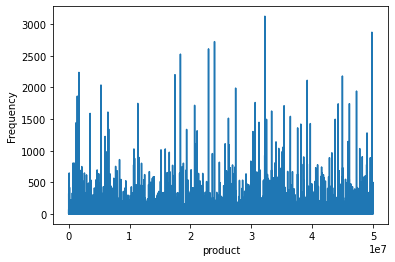

In [ ]:
# Popularity of different categories
product_orderd = train.groupby('product_id')['quantity'].sum()
print(product_orderd)
product_orderd.plot()
plt.xlabel("product")
plt.ylabel("Frequency")

## Trends and seasonality

### Egyes vásárlók átlagos vásárlóereje

Először is arra voltam kíváncsi hogy mennyit költenek átlagosan az egyes vásárlók heti felbontásban. Ez betekintést enged a vásárlók költekezési hajlandóságára, vásárló erejének alakulására és az aktuális trendekre. 

Az elemzés során azt tapasztaltam, hogy 2012 és 2013 során az egyes vásárlók által elköltött összeg viszonylag stacionárius maradt, kevés növekedést produkálva évközben. Illetve nagyobb ingadozást mutatva 2012 első felében.

Azonban a vásárlók költekezési hajlandósága kb 15%-ot növekedett 2013 őszétől kezdődően és ez a trend folytatódhat egy kissebb korrekció után.

Ez viszonylag jól látható a két hetes mozgóátlag alakulásából is. 

purchase_date
2012-01-01     79.837442
2012-01-08     89.525526
2012-01-15     92.378837
2012-01-22     79.597782
2012-01-29     77.923136
                 ...    
2013-12-08     99.131929
2013-12-15    101.527937
2013-12-22     98.889247
2013-12-29    103.072028
2014-01-05    105.582673
Freq: W-SUN, Name: sales_amount, Length: 106, dtype: float64


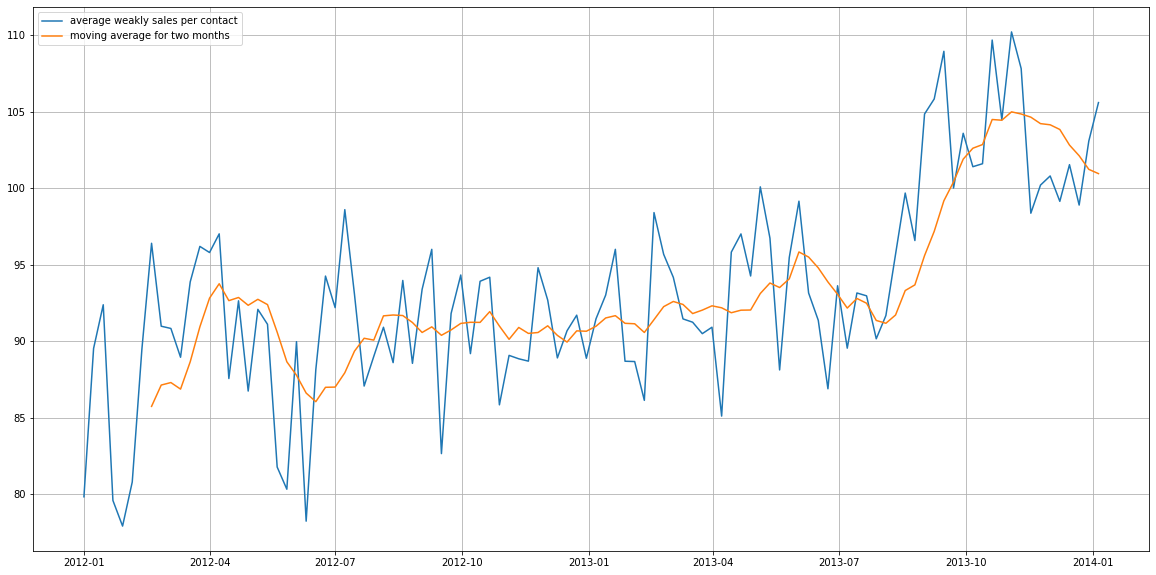

In [ ]:
# PREP
# Data Preparation: input should be float type
train['sales_amount'] = train['sales_amount'] * 1.0

# mennyit költenek a vásárlók átlagosan heti felbontásban
average_sales_per_customer = train.groupby(["purchase_date","contact_id" ]).sum().reset_index().set_index("purchase_date").resample("W").mean()["sales_amount"]
print(average_sales_per_customer)
plt.figure(figsize=(20,10))
plt.plot(average_sales_per_customer)
plt.plot(average_sales_per_customer.rolling(window=8).mean())
plt.legend(['average weakly sales per contact', 'moving average for two months'])
plt.grid()
plt.show()


### Összes költés heti feldontásban

Érdemes megnézni, hogy hogyan változik a vásárlók összesített heti költése, hiszen végső soron ez adja a bolt bevételét. 

A két éves intervallumból az látszik, hogy a második évben kissebb összeget költöttek a vásárlók. 

Illetve az elköltött összeg a karácsonyi időszakban jelentős mértékben megukrik. Ez egy reális viselkedés.

purchase_date
2012-01-01     44629.13
2012-01-08    447269.53
2012-01-15    474272.95
2012-01-22    371005.26
2012-01-29    319796.55
                ...    
2013-12-08    546316.06
2013-12-15    547743.22
2013-12-22    381020.27
2013-12-29    239436.32
2014-01-05     80981.91
Freq: W-SUN, Name: sales_amount, Length: 106, dtype: float64


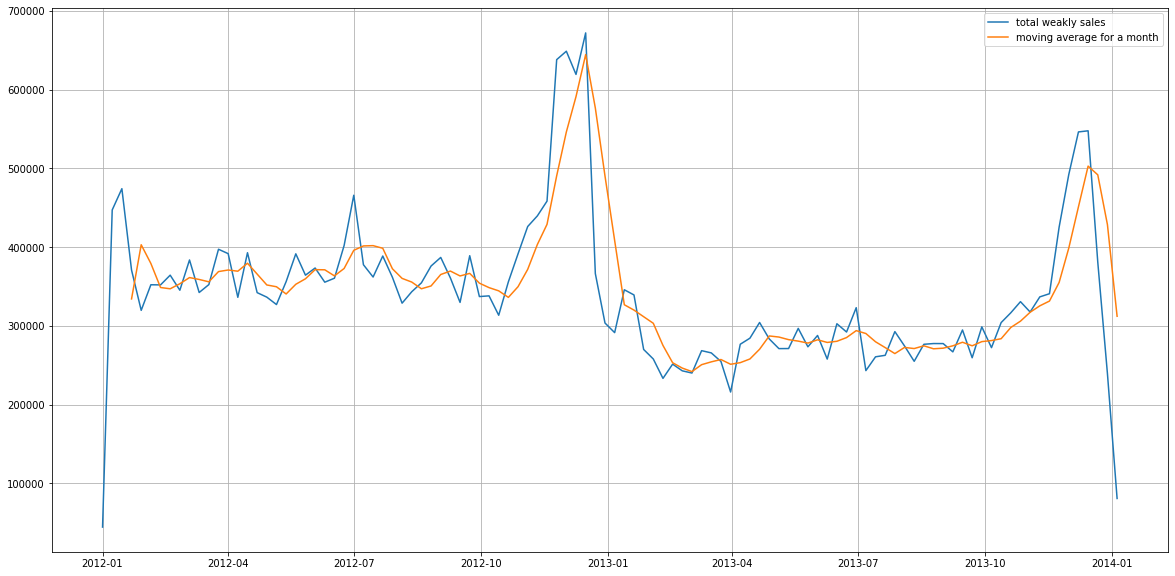

In [ ]:
# mennyit költenek a vásárlók összesen heti felbontásban
total_sales = train.set_index("purchase_date").resample("W").sum()['sales_amount']
print(total_sales)
plt.figure(figsize=(20,10))
plt.plot(total_sales)
plt.plot(total_sales.rolling(window=4).mean())
plt.legend(['total weakly sales', 'moving average for a month'])
plt.grid()
plt.show()
#total_sales.plot()

### Vásárlók száma

Természetesen adódik a felvetés, hogyha az utolsó időszakban megnövekedett a vásárlók átlagos költése, és mégis kevesebb a bevételünk, akkor valószínűleg csökken a vevőkörünk. 

Ezt a következő vizualizáció is mutatja, illetve megfigyelhető a bevétel és a vásárlók száma közötti korreláció.


purchase_date
2012-01-01     559
2012-01-08    4996
2012-01-15    5134
2012-01-22    4661
2012-01-29    4104
              ... 
2013-12-08    5511
2013-12-15    5395
2013-12-22    3853
2013-12-29    2323
2014-01-05     767
Freq: W-SUN, Name: contact_id, Length: 106, dtype: int64


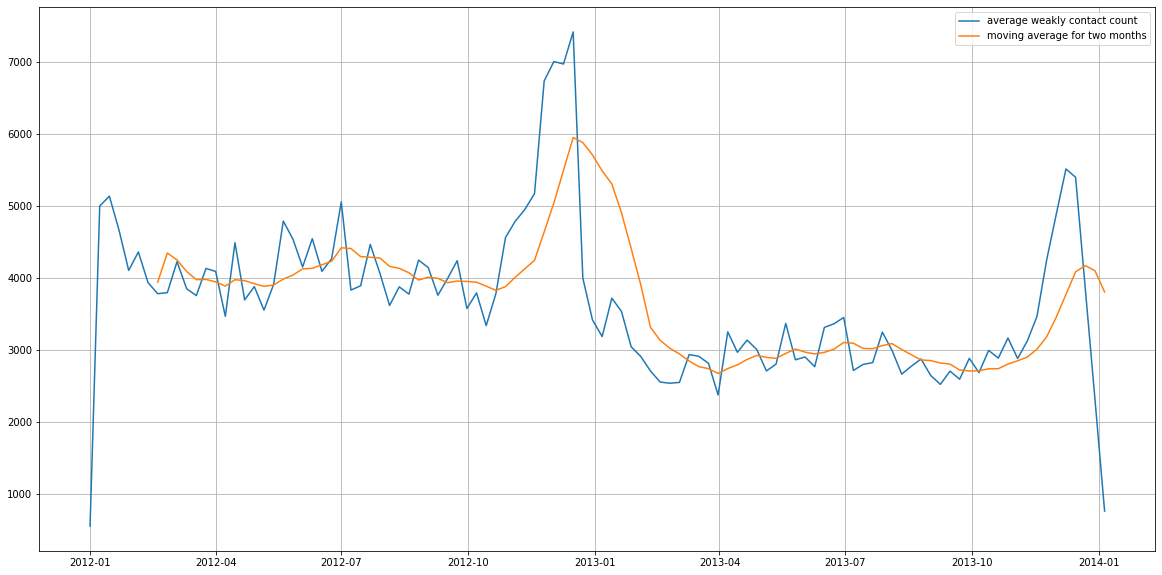

In [ ]:
# Vásárlók száma heti felbontásban
average_customer_count = train.groupby(["purchase_date","contact_id" ]).count().reset_index().set_index("purchase_date")["contact_id"].resample("W").count()
print(average_customer_count)
plt.figure(figsize=(20,10))
plt.plot(average_customer_count)
plt.plot(average_customer_count.rolling(window=8).mean())
plt.legend(['average weakly contact count', 'moving average for two months'])
plt.grid()
plt.show()

# Predictive modelling

Idősoros analízissel prediktív modell készíthető a jövőbeli trendek megbecsülésére. Ehhez két különböző modellt is használtam. 

A különböző módszereket pedig RMS hiba (Root mean Square Error / négyzetes hibafüggvény) alapján hasonlítom üssze

## Seasonal AutoRegressive Integrated Moving Average

Az AutoRegressive Integrated Moving Average idősoros adatok jövőbeli értékének predikciójára használatos. Ezen módszernek egy kiegészítése a SARIMA, mely szezonalitással rendelkező egyváltozós idősor-adatok predikciójára használt. 

Mint láthattuk az előző részben, az adathalmazunk erős szezonalitással rendelkezik.

In [ ]:
# ARIMA (Autoregressive Integrated Moving Average)
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))



Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
def fit_arima(train_arima): 
  # Hyperparameter tuning for ARIMA
  # Determing p,d,q combinations with AIC scores.

  # train_a = train.copy()

  # # mennyit költenek a vásárlók átlagosan hetente
  # train_arima2 = train_a.groupby(["purchase_date","contact_id" ]).sum().reset_index()
  # train_arima = train_arima2.set_index("purchase_date").resample("W").mean()["sales_amount"]

  # # mennyit költenek a vásárlók összesen hetente
  # train_arima = train_a.set_index("purchase_date").resample("W").sum()['sales_amount']

  min = float('inf')
  order = order_seasonal = None
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(train_arima,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
              results = mod.fit()
              # print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
              if results.aic < min:
                min = results.aic
                order = param
                order_seasonal = param_seasonal
          except:
              continue
  print("Minimal params: ARIMA{}x{}12 - AIC:{}".format( order,order_seasonal, min))

  # Fitting the data to ARIMA model 
  model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                  order=order,
                                  seasonal_order=order_seasonal,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
  results_sarima = model_sarima.fit()
  print(results_sarima.summary().tables[1])

  # Checking diagnostic plots
  print("checking diagnostic plots")
  results_sarima.plot_diagnostics(figsize=(10, 10))
  plt.show()

  return model_sarima, results_sarima
        

In [ ]:
def model_prediction(train_arima,results_sarima):
  # Model Prediction
  # Predictions are performed for the 01th Jan' 2013 onwards of the train data.

  pred = results_sarima.get_prediction(start=pd.to_datetime('2013-01-06'), dynamic = False)

  # Get confidence intervals of forecasts
  print("Forecast from 2013-01-06")
  pred_ci = pred.conf_int()
  ax = train_arima["2012":].plot(label = "observed", figsize=(15, 7))
  pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
  ax.fill_between(pred_ci.index, 
                  pred_ci.iloc[:, 0], 
                  pred_ci.iloc[:, 1], 
                  color = "k", alpha = 0.05)
  ax.set_xlabel("Date")
  ax.set_ylabel("Sales")
  plt.legend
  plt.show()
  train_arima_forecasted = pred.predicted_mean
  train_arima_truth = train_arima["2013-01-06":]

  # Calculating the error
  rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
  print("Root Mean Squared Error: ", rms_arima)

In [ ]:
'''
Generate dates to index predictions.
:parameter
    :param start: str - "yyyy-mm-dd"
    :param end: str - "yyyy-mm-dd"
    :param n: num - length of index
    :param freq: None or str - 'B' business day, 'D' daily, 'W' 
                 weekly, 'M' monthly, 'A' annual, 'Q' quarterly
'''
def utils_generate_indexdate(start, end=None, n=None, freq="W"):
    if end is not None:
        index = pd.date_range(start=start, end=end, freq=freq)
    else:
        index = pd.date_range(start=start, periods=n, freq=freq)
    index = index[1:]
    print("--- generating index date --> start:", index[0], 
          "| end:", index[-1], "| len:", len(index), "---")
    return index
    
def utils_plot_forecast(dtf, zoom=30, figsize=(20,10)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    
    dtf[["ts","forecast"]].plot(color=["black","red"], grid=True, title="History + Future")
    
    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

def forecast_arima(ts, model, pred_ahead=None, end=None, freq="W", zoom=30, figsize=(15,10)):
    ## fit
    model = model.fit()
    dtf = ts.to_frame(name="ts")
    dtf["model"] = model.fittedvalues
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    
    ## index
    index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)
    
    ## forecast
    preds = model.forecast(len(index))
    dtf = dtf.append(preds.to_frame(name="forecast"))
    
    ## plot
    print("Forecast in the uncertain future")
    dtf = utils_plot_forecast(dtf, zoom=zoom)
    
    return dtf

### ARIMA predikció az összes költésre

Minimal params: ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1974.009647690955
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1242      0.174      0.714      0.475      -0.217       0.465
ma.S.L12      -0.9794      0.077    -12.774      0.000      -1.130      -0.829
sigma2       5.37e+09   5.05e-12   1.06e+21      0.000    5.37e+09    5.37e+09
checking diagnostic plots


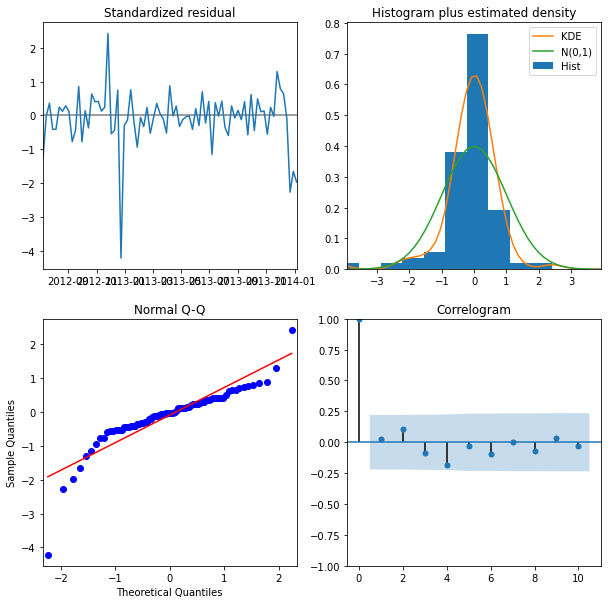

Forecast from 2013-01-06


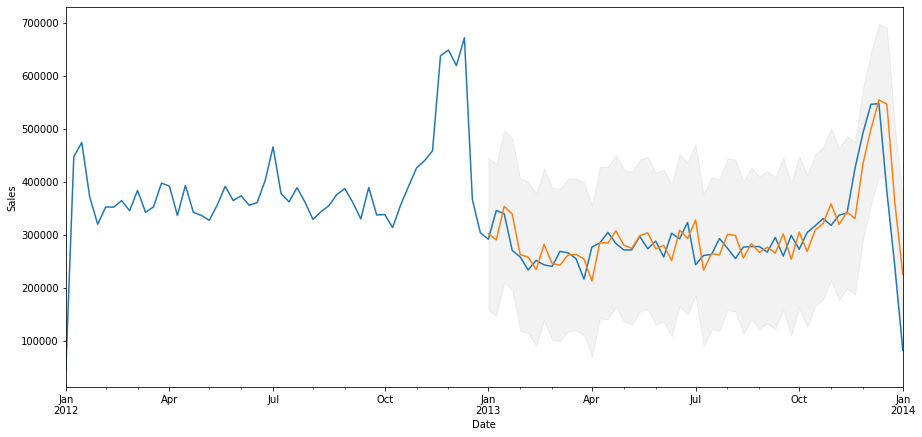

Root Mean Squared Error:  48015.85675778709
--- generating index date --> start: 2014-01-12 00:00:00 | end: 2015-05-31 00:00:00 | len: 73 ---
Forecast in the uncertain future


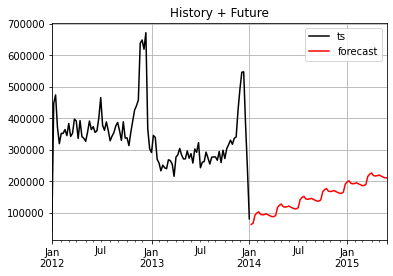

In [ ]:
# prediction with ARIMA for the total sales
model, results = fit_arima(total_sales)
model_prediction(total_sales,results)
future = forecast_arima(total_sales, model, end="2015-06-01")

**Diagnosztika**

A diagnosztikai ábrákon látszik, hogy a reziduumok által követett eloszlás hozzávetőlegesen egy nulla közepű normál valószínűségi eloszlás.

A pontatlanságokat, az ünnepek során lévő kiugró értékek okozzák. 

**Predikció**

A 2013-01-től prediktált értékek jól követik a ground truth értékeket.

**Bizonytalan jövő**

A bizonytalan jövőben történő előrejelzést is ábrázoltam, természetesen az előzővel ellentétben itt hosszú távon probáljuk megjósolni a trend alakulását a model segíségével, ami az idő során előrehaladva egyre növekvő hibát okoz. 
Az ARIMA úgynevezett one-step-ahead előrejelzést valósít meg, ami akkor működik jól ha az új értékeket visszacsatoljuk.



### ARIMA predikció a vásárlók átlagos költésére

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Minimal params: ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:492.84142535713585
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2193      0.170      1.294      0.196      -0.113       0.552
ma.L1         -0.8737      0.075    -11.606      0.000      -1.021      -0.726
ma.S.L12      -1.0000   1151.819     -0.001      0.999   -2258.525    2256.525
sigma2        21.6754    2.5e+04      0.001      0.999   -4.89e+04     4.9e+04
checking diagnostic plots


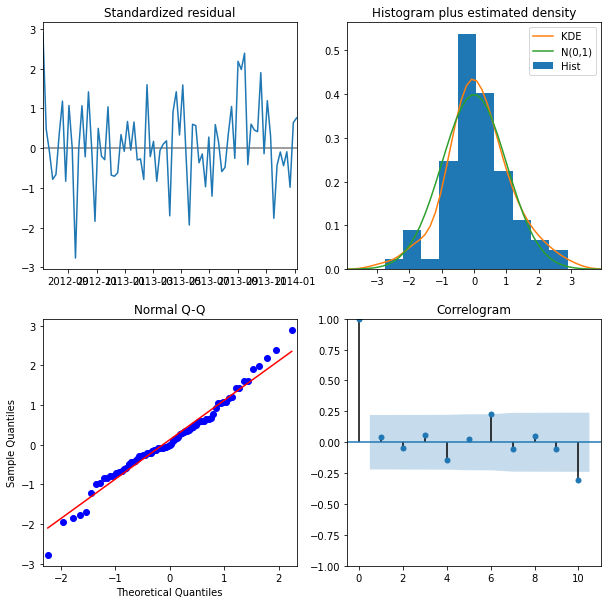

Forecast from 2013-01-06


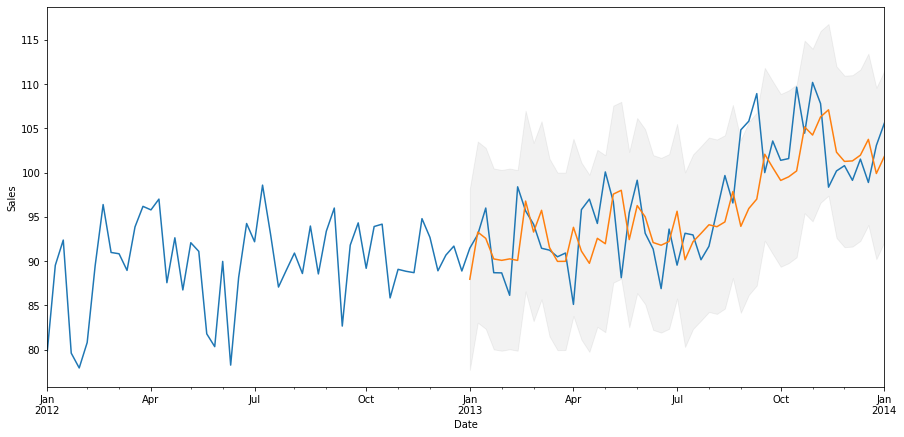

Root Mean Squared Error:  4.833818902985541
--- generating index date --> start: 2014-01-12 00:00:00 | end: 2015-05-31 00:00:00 | len: 73 ---
Forecast in the uncertain future


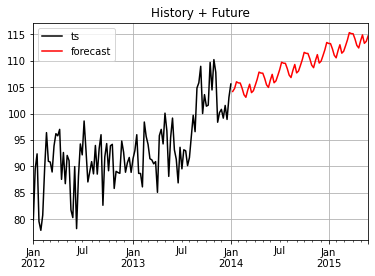

In [ ]:
# model prediction for average sales
model, results = fit_arima(average_sales_per_customer)
model_prediction(average_sales_per_customer,results)
future = forecast_arima(average_sales_per_customer, model, end="2015-06-01")

**Diagnosztika**

A diagnosztikai ábrákon látszik, hogy a paraméterek eloszlása sokkal inkább hasonlít a standard nulla közepű normális eloszláshoz, hiszen ez az adathalmaz sokkal kevesebb kiugró értéket is tartalmaz, és kevesebb a szezonális hatás a vásárlók által átlagosan elköltött összegben. 

A pontatlanságokat, az ünnepek során lévő kiugró értékek okozzák. 

**Predikció**

A 2013-01-től prediktált értékek hasonlóan jól követik a ground truth értékeket. Az RMSE kimondottan jónak mondható.

**Bizonytalan jövő**

A bizonytalan jövőben történő predikció itt is 
követi az utolsó trendet a pénzköltési szokásokban. 


# Facebook prophet

A másik modell amit használtam a predikcióra az a Prophet, amely a Facebook által fejlesztett, nyílt forráskódú idősoros predikcióra használható additív modellt használ.

A Prophet jól kezeli a szezonális hatásokat az adathalmazban, illetve a külöféle trendváltozásokat, és outliereket, feltéve hogy kellő szezonnyi adat áll rendelkezésre. 

In [ ]:
# Creating a train dataset
train_prophet = train.copy()
train_prophet.reset_index(level=0, inplace=True)

# converting col names to specific names as required by Prophet library
train_prophet = train_prophet.rename(columns = {'purchase_date': 'ds',
                                'sales_amount': 'y'})

# Downsampling to week because modelling on daily basis takes a lot of time
ts_week_prophet = train_prophet.set_index("ds").resample("W").sum()
average_sales = train_prophet.groupby(["ds","contact_id" ]).sum().reset_index().set_index("ds").resample("W").mean()

# Resetting the index
total_sales_prophet = ts_week_prophet.reset_index()
average_sales_prophet = average_sales.reset_index()

In [36]:
def pred_prophet(ts):
  # Fitting data to Prophet model
  prophet_1 = Prophet() 
  prophet_1.fit(ts)

  future_1 = prophet_1.make_future_dataframe(periods = 52, freq = "W") 
  forecast_1 = prophet_1.predict(future_1)
  forecast_1[["ds", "yhat", "yhat_lower", "yhat_upper"]]
  # Visualizing predicions of forecast

  prophet_1.plot(forecast_1, figsize=(30, 10));


  # Checking the RMSE of Prophet model
  metric_prophet_1 = forecast_1.set_index('ds')[['yhat']].join(ts.set_index('ds').y).reset_index()
  metric_prophet_1.dropna(inplace=True)
  rms_prophet_1 = mean_squared_error(metric_prophet_1.y, metric_prophet_1.yhat)
  print("Root Mean Squared Error: ", rms_prophet_1)
  return prophet_1, forecast_1

### Prophet predikció a teljes bevételre. 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Root Mean Squared Error:  1985380752.280054


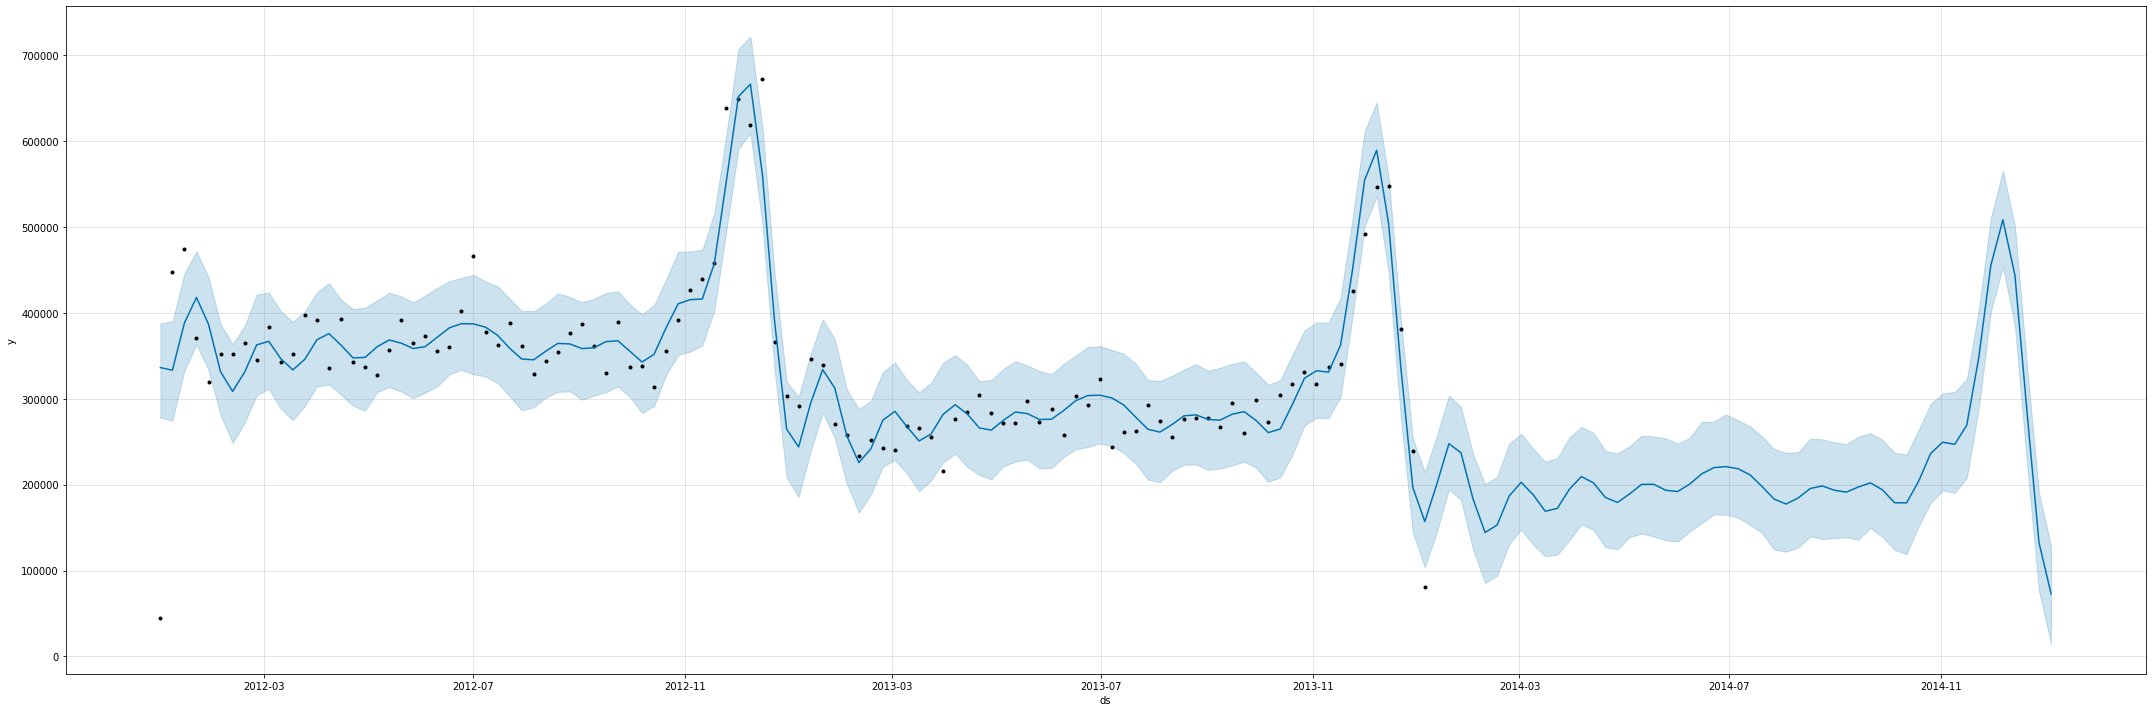

In [37]:
a, b = pred_prophet(total_sales_prophet)

Mivel a 2 évnyi adat hasonló szezonális tulajdonságokkal rendelkezik, ezért a következő évi előrejelzés is hasonlóan követi az eddigi két éves mintát egy kevés csökkenéssel a vásárlási számban. 

Érdekes, hogy az RMSE sokkal nagyobb mint az ARIMA modell esetében. 
A modell pontossága azonban javítható például az ünnepnapok időpontjai alapján. 

### Prophet predikció az átlagos költésekre. 


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Root Mean Squared Error:  15.351923685662811


(<fbprophet.forecaster.Prophet at 0x7f4fc1619c50>,
             ds       trend  ...  multiplicative_terms_upper        yhat
 0   2012-01-01   87.670592  ...                         0.0   86.715905
 1   2012-01-08   87.748233  ...                         0.0   89.350724
 2   2012-01-15   87.825873  ...                         0.0   88.626651
 3   2012-01-22   87.903513  ...                         0.0   84.875524
 4   2012-01-29   87.981153  ...                         0.0   81.943690
 ..         ...         ...  ...                         ...         ...
 153 2014-12-07  117.499173  ...                         0.0  117.178880
 154 2014-12-14  117.783133  ...                         0.0  115.153842
 155 2014-12-21  118.067094  ...                         0.0  113.967102
 156 2014-12-28  118.351054  ...                         0.0  115.708463
 157 2015-01-04  118.635015  ...                         0.0  119.129523
 
 [158 rows x 16 columns])

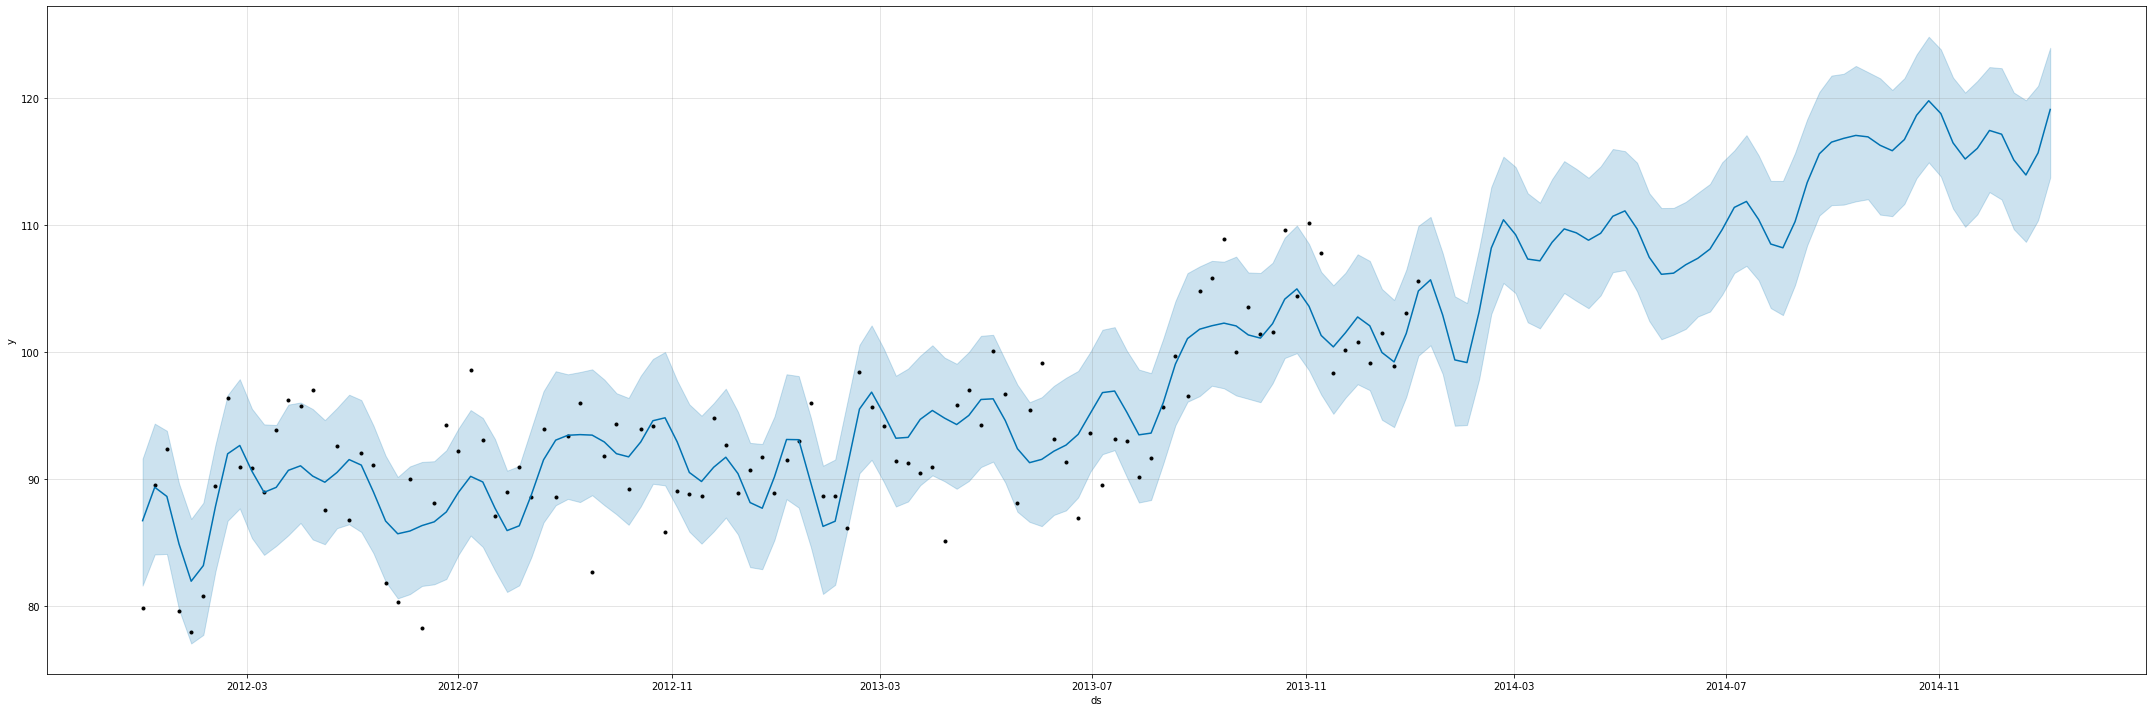

In [38]:
pred_prophet(average_sales_prophet)

Mivel a vásárlók átlagos költésére az adatok szórása sokkal kissebb ezért az RMSE itt jelentősen kissebb. Természetesen itt is nagyobb mint az ARIMA esetében, de vegyük észre, hogy a Prophet inkább a távoli jövőben történő predikcióra hatásosabb, míg az ARIMA a *One-step-ahed predikcióra*.

Látható, hogy az modell előrejezése szerint a vásárlók által átlagosan elköltött összegben továbbra is növekvő trend figyelhető meg.
